In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd

df = pd.read_csv('/kaggle/input/stock-and-sales-data/data.csv',encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [8]:
print(df.shape)
print(df.columns)

(541909, 8)
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [9]:
print(df.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


# Data Cleaning and Preprocessing

## 1.Convert InvoiceDate to datetime

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

## 2.Handling Missing, Zero and Negative Values

In [11]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

neg_zero_values = pd.DataFrame({
    'Negative Count': (numeric_df < 0).sum(),
    'Zero Count': (numeric_df == 0).sum()
})

print(neg_zero_values)

            Negative Count  Zero Count
Quantity             10624           0
UnitPrice                2        2515
CustomerID               0           0


In [12]:
missing_values = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': df.isnull().mean() * 100
})

print(missing_values)

             Missing Count  Missing Percentage
InvoiceNo                0            0.000000
StockCode                0            0.000000
Description           1454            0.268311
Quantity                 0            0.000000
InvoiceDate              0            0.000000
UnitPrice                0            0.000000
CustomerID          135080           24.926694
Country                  0            0.000000


* We have missing values in Description and CustomerID

In [13]:
missing_desc = df[df['Description'].isnull()]
stock_counts = missing_desc[['StockCode','UnitPrice']].value_counts()
print(stock_counts)

StockCode     UnitPrice
35965         0.0          10
23084         0.0          10
22084         0.0           9
22451         0.0           6
23348         0.0           5
                           ..
22453         0.0           1
22454         0.0           1
22461         0.0           1
22467         0.0           1
gift_0001_30  0.0           1
Name: count, Length: 960, dtype: int64


**Observation :-** <br> We find that certain StockCodes have missing descriptions, we could consider joining or inferring the description from the StockCodes whose description inside our dataset is presnet.
and also fill its unit prices as all missing description has unit price zero

In [14]:
def fill_missing_desc_and_unitprice(row):
    # Process rows where Description is missing
    if pd.isnull(row['Description']):
        stock = row['StockCode']
        # Get valid (non-missing) Descriptions for this StockCode
        valid_desc = df.loc[(df['StockCode'] == stock) & (df['Description'].notnull()), 'Description']
        if len(valid_desc) > 4:
            mode_desc = valid_desc.mode()
            if not mode_desc.empty:
                # Update missing Description with the most frequent valid Description
                row['Description'] = mode_desc.iloc[0]
                
                # Now, for the same stock code, update UnitPrice if it's <= 0
                if row['UnitPrice'] <= 0:
                    valid_prices = df.loc[(df['StockCode'] == stock) & (df['UnitPrice'] > 0), 'UnitPrice']
                    if len(valid_prices) > 4:
                        mode_price = valid_prices.mode()
                        if not mode_price.empty:
                            row['UnitPrice'] = mode_price.iloc[0]
    return row

df = df.apply(fill_missing_desc_and_unitprice, axis=1)

In [15]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

neg_zero_values = pd.DataFrame({
    'Negative Count': (numeric_df < 0).sum(),
    'Zero Count': (numeric_df == 0).sum()
})

print(neg_zero_values)

            Negative Count  Zero Count
Quantity             10624           0
UnitPrice                2        1366
CustomerID               0           0


In [16]:
missing_values = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': df.isnull().mean() * 100
})

print(missing_values)

             Missing Count  Missing Percentage
InvoiceNo                0            0.000000
StockCode                0            0.000000
Description            305            0.056283
Quantity                 0            0.000000
InvoiceDate              0            0.000000
UnitPrice                0            0.000000
CustomerID          135080           24.926694
Country                  0            0.000000


In [17]:
print(df.shape)

(541909, 8)


* Filled missing `Description` using the most frequent value for the same `StockCode` (if it appeared >4 times). Also, updated `UnitPrice` for missing descriptions using the most common valid price for the same `StockCode`.

In [18]:
df['CustomerID'] = df['CustomerID'].fillna(-1)

# Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [19]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

neg_zero_values = pd.DataFrame({
    'Negative Count': (numeric_df < 0).sum(),
    'Zero Count': (numeric_df == 0).sum()
})

print(neg_zero_values)

            Negative Count  Zero Count
Quantity                 0           0
UnitPrice                0           0
CustomerID          132727           0


In [20]:
missing_values = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': df.isnull().mean() * 100
})

print(missing_values)

             Missing Count  Missing Percentage
InvoiceNo                0                 0.0
StockCode                0                 0.0
Description              0                 0.0
Quantity                 0                 0.0
InvoiceDate              0                 0.0
UnitPrice                0                 0.0
CustomerID               0                 0.0
Country                  0                 0.0


In [21]:
print(df.shape)

(530611, 8)


## 3. Remove Duplicates

In [22]:
df = df.drop_duplicates()

## 4.Verify Changes

In [23]:
print(df.isnull().sum())
print(df.dtypes)
print(df.describe())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object
            Quantity                    InvoiceDate      UnitPrice  \
count  525385.000000                         525385  525385.000000   
mean       10.662729  2011-07-04 15:13:56.968508928       3.922573   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         1.000000            2011-03-28 12:13:00       1.250000   
50%         4.000000            2011-07-20 11:07:00       2.080000   
75%        11.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   13541.330000   
std       156.472553                 

# Exploratory Data Analysis (EDA)! 🚀

## 1. Understanding Sales Trends

In [24]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

In [25]:
df_sales_per_day = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()

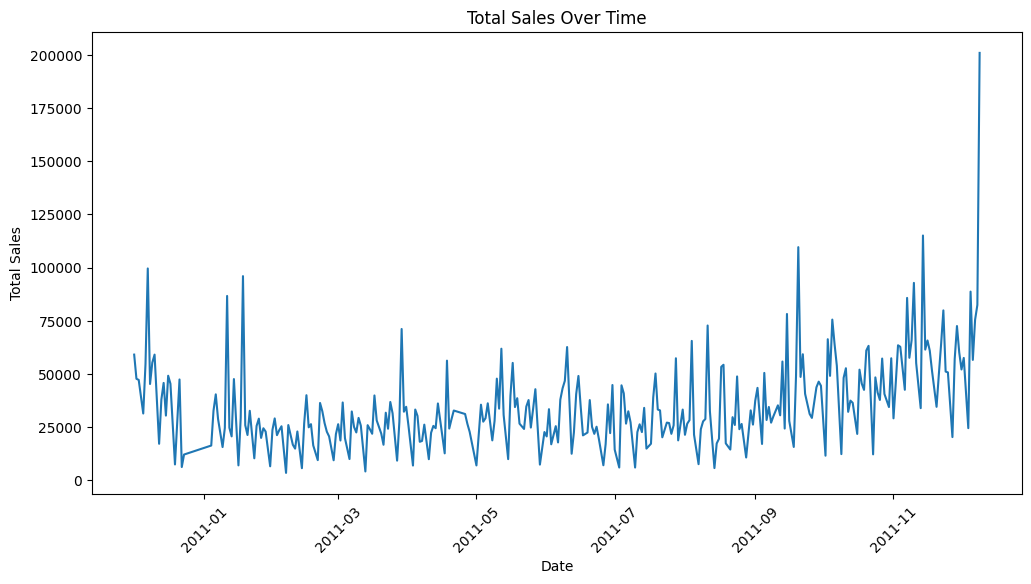

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_sales_per_day['InvoiceDate'], y=df_sales_per_day['TotalSales'])
plt.xticks(rotation=45)
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

* Observations from the Sales Trend
   - Seasonal Trends: There are noticeable peaks at regular intervals, suggesting a possible seasonality in sales. This could be due to events, promotions, or seasonal demand for certain products.
  - Increasing Trend (End of Graph): Towards the end of the timeline (Nov-Dec 2011), there is a increase in total sales which indicate that its grwoing its sales year by year

## 2. Customer Behavior Analysis

In [27]:
# Most Frequent Customers
top_customers = df['CustomerID'].value_counts().head(11)
print(top_customers)

CustomerID
-1.0        132693
 17841.0      7676
 14911.0      5670
 14096.0      5111
 12748.0      4412
 14606.0      2677
 15311.0      2366
 14646.0      2076
 13089.0      1814
 13263.0      1667
 14298.0      1637
Name: count, dtype: int64


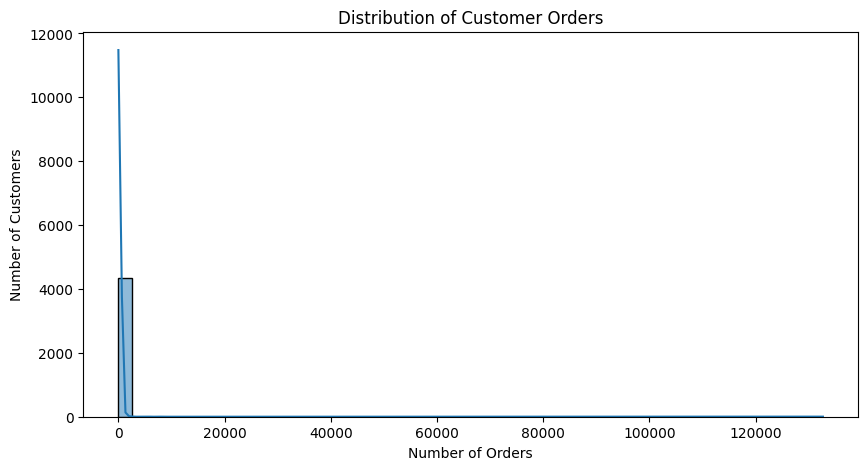

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(df['CustomerID'].value_counts(), bins=50, kde=True)
plt.title("Distribution of Customer Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.show()

Lets remove outlier and then analyise it.

In [29]:
order_counts = df['CustomerID'].value_counts()

In [30]:
order_counts

CustomerID
-1.0        132693
 17841.0      7676
 14911.0      5670
 14096.0      5111
 12748.0      4412
             ...  
 17291.0         1
 15657.0         1
 16093.0         1
 15823.0         1
 13120.0         1
Name: count, Length: 4339, dtype: int64

In [31]:
import numpy as np

# Calculate IQR
order_counts = df['CustomerID'].value_counts()
Q1 = np.percentile(order_counts, 25) 
Q3 = np.percentile(order_counts, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_customers = order_counts[(order_counts >= lower_bound) & (order_counts <= upper_bound)]

# Filter original DataFrame to keep only non-outlier customers
df_filtered = df[df['CustomerID'].isin(filtered_customers.index)]

print(f"Original dataset size: {df.shape}")
print(f"Filtered dataset size: {df_filtered.shape}")

Original dataset size: (525385, 9)
Filtered dataset size: (211320, 9)


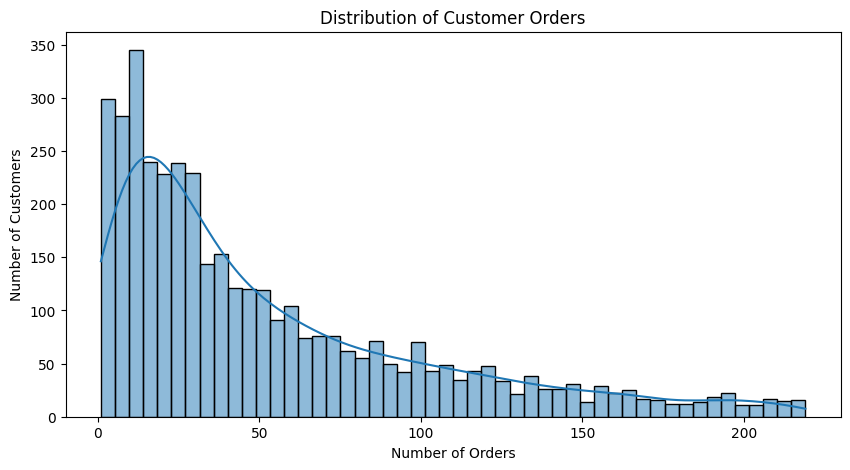

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(df_filtered['CustomerID'].value_counts(), bins=50, kde=True)
plt.title("Distribution of Customer Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.show()

* Right-Skewed Distribution
  - Most customers place a small number of orders (e.g., between 1-50).
  - The frequency decreases as the number of orders increases.

## 3.Top Products & Revenue Contributors

In [33]:
# Best-Selling Products by Quantity
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
print(top_products)

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        78033
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54951
JUMBO BAG RED RETROSPOT               48371
WHITE HANGING HEART T-LIGHT HOLDER    37872
POPCORN HOLDER                        36749
PACK OF 72 RETROSPOT CAKE CASES       36396
ASSORTED COLOUR BIRD ORNAMENT         36362
RABBIT NIGHT LIGHT                    31555
MINI PAINT SET VINTAGE                26633
Name: Quantity, dtype: int64


In [34]:
# Best-Selling Products by Revenue
top_revenue_products = df.groupby("Description")["TotalSales"].sum().sort_values(ascending=False).head(10)
print(top_revenue_products)

Description
DOTCOM POSTAGE                        209538.77
REGENCY CAKESTAND 3 TIER              174156.54
PAPER CRAFT , LITTLE BIRDIE           168469.60
POSTAGE                               138401.88
WHITE HANGING HEART T-LIGHT HOLDER    106236.72
PARTY BUNTING                          99445.23
JUMBO BAG RED RETROSPOT                94159.81
MEDIUM CERAMIC TOP STORAGE JAR         81700.92
Manual                                 77752.82
RABBIT NIGHT LIGHT                     68567.31
Name: TotalSales, dtype: float64


## 4.Country-wise Sales Distribution

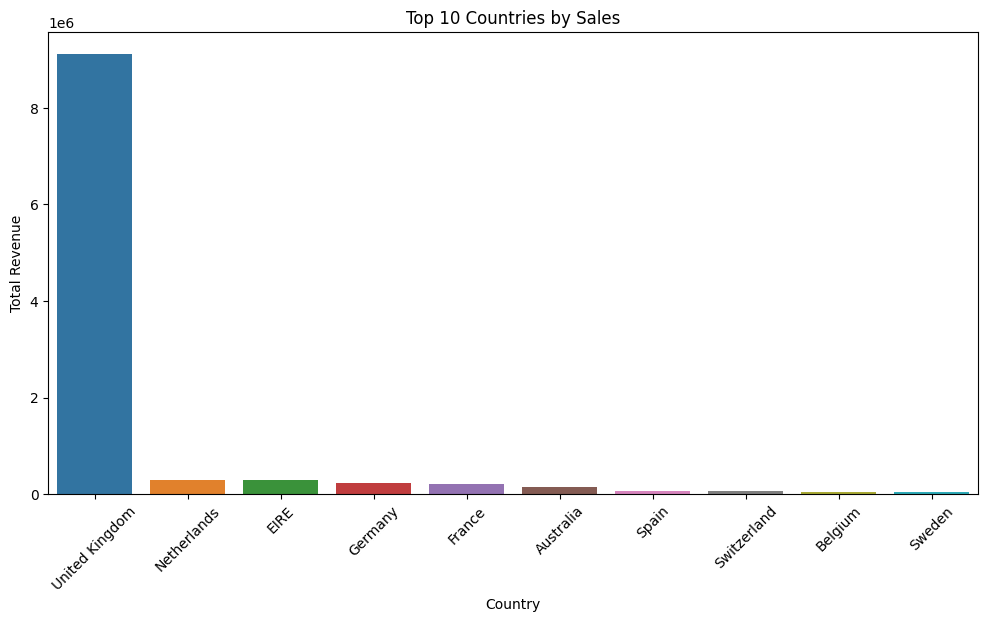

In [35]:
country_sales = df.groupby("Country")["TotalSales"].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=country_sales.index[:10], y=country_sales.values[:10])
plt.xticks(rotation=45)
plt.title("Top 10 Countries by Sales")
plt.ylabel("Total Revenue")
plt.show()

## 5.Visualizing Order Frequency & Revenue Patterns

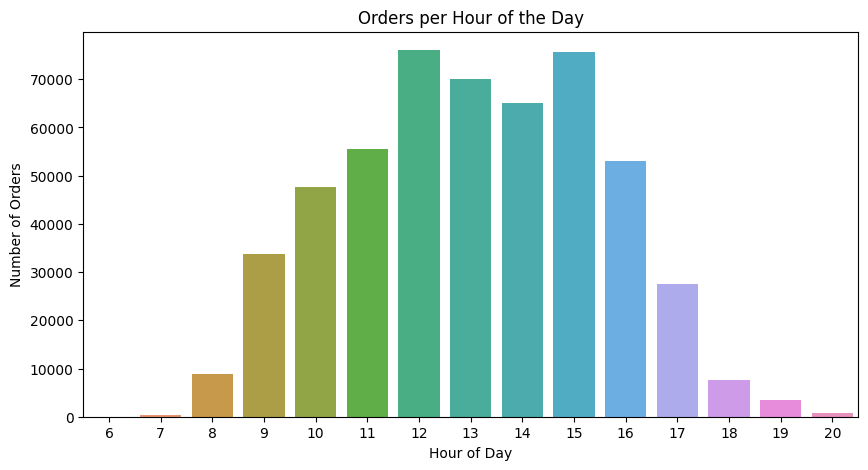

In [36]:
df['Hour'] = df['InvoiceDate'].dt.hour
orders_by_hour = df.groupby("Hour")["InvoiceNo"].count()

plt.figure(figsize=(10,5))
sns.barplot(x=orders_by_hour.index, y=orders_by_hour.values)
plt.title("Orders per Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.show()

This will show when customers place the most orders.

# Use ARIMA model for prediction

#### We want to predict future sales based on past trends. Since we have InvoiceDate

In [37]:
df['Date'] = df['InvoiceDate'].dt.date

In [38]:
daily_sales = df.groupby('Date')['TotalSales'].sum().reset_index()

In [39]:
daily_sales.head()

,Date,TotalSales
0,2010-12-01,59053.99
1,2010-12-02,47700.67
2,2010-12-03,47151.63
3,2010-12-05,31364.63
4,2010-12-06,54747.36


In [40]:
df.to_csv('/kaggle/working/cleaned_data.csv', index=False)
print("Data exported for Power BI visualization!")

Data exported for Power BI visualization!


## 1. Data Transformation

In [41]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Small constant to handle zero values
log_offset = 1e-6

# Log transformation to stabilize variance
daily_sales["TotalSales_Log"] = np.log(daily_sales["TotalSales"] + log_offset)

# Min-Max Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
daily_sales["TotalSales_Scaled"] = scaler.fit_transform(daily_sales["TotalSales_Log"].values.reshape(-1, 1))

daily_sales.head()

,Date,TotalSales,TotalSales_Log,TotalSales_Scaled
0,2010-12-01,59053.99,10.986207,0.698985
1,2010-12-02,47700.67,10.772701,0.646493
2,2010-12-03,47151.63,10.761124,0.643647
3,2010-12-05,31364.63,10.353436,0.543415
4,2010-12-06,54747.36,10.910484,0.680368


## 2. Visualize Daily Revenue Trend

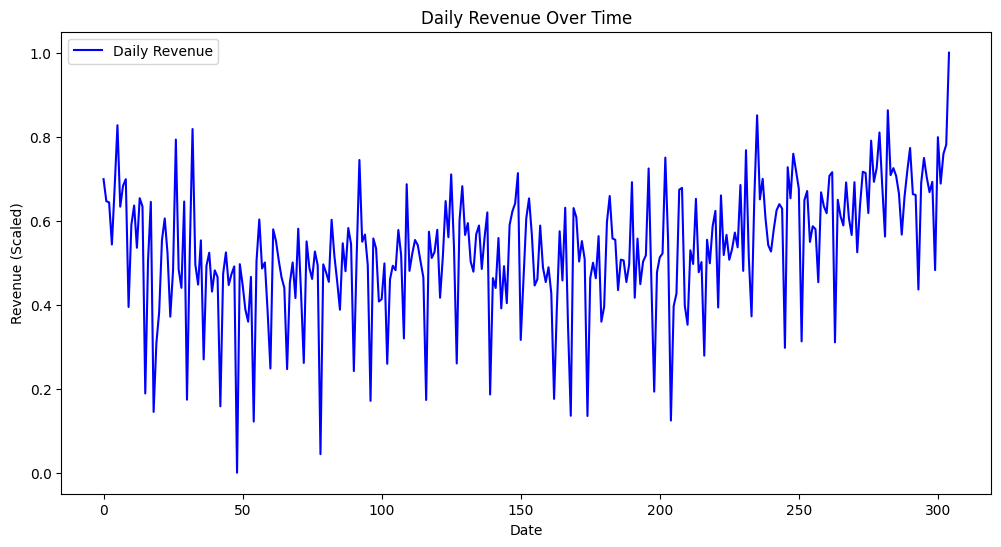

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales["TotalSales_Scaled"], label='Daily Revenue', color='blue')
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue (Scaled)')
plt.legend()
plt.show()

## 3. Perform ADF Test for Stationarity

### Key Observations from the Graph:

#### Revenue Fluctuations
- The revenue varies significantly day-to-day, indicating high volatility in sales.
- The peaks and troughs suggest that revenue has periodic variations or irregular spikes.

#### Trend Analysis
- It looks like there is some upward movement towards the later part of the time series.
- This could indicate seasonal growth or a gradual increase in business revenue over time.

#### Possible Stationarity Issues
- The presence of sharp fluctuations suggests non-stationarity, which could impact ARIMA modeling.
- The ADF test result will confirm whether differencing is needed.

In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(daily_sales["TotalSales_Scaled"])

print("\n📊 ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"{key}: {value}")

if adf_result[1] <= 0.05:
    print("\n✅ The time series is stationary (p-value <= 0.05).")
else:
    print("\n❌ The time series is not stationary (p-value > 0.05). Differencing is needed.")


📊 ADF Test Results:
ADF Statistic: -1.1616192362565598
p-value: 0.6898845180674968
Critical Values:
1%: -3.452867117291862
5%: -2.8714554160827745
10%: -2.5720532321867466

❌ The time series is not stationary (p-value > 0.05). Differencing is needed.


In [44]:
# Apply first-order differencing
daily_sales['TotalSales_Diff'] = daily_sales['TotalSales_Scaled'].diff().dropna()

# Perform ADF test on the DIFFERENCED series
adf_result_diff = adfuller(daily_sales['TotalSales_Diff'].dropna())  # <-- FIXED!

print("\n📊 ADF Test Results (After First-Order Differencing):")
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"{key}: {value}")

if adf_result_diff[1] <= 0.05:
    print("\n✅ The differenced time series is now stationary!")
else:
    print("\n❌ The time series is still not stationary. Try second-order differencing.")


📊 ADF Test Results (After First-Order Differencing):
ADF Statistic: -8.646575459452203
p-value: 5.2510276756222305e-14
Critical Values:
1%: -3.452867117291862
5%: -2.8714554160827745
10%: -2.5720532321867466

✅ The differenced time series is now stationary!


## 4. Auto-Correlation & Partial Auto-Correlation Analysis (ACF & PACF)

 Plot ACF & PACF

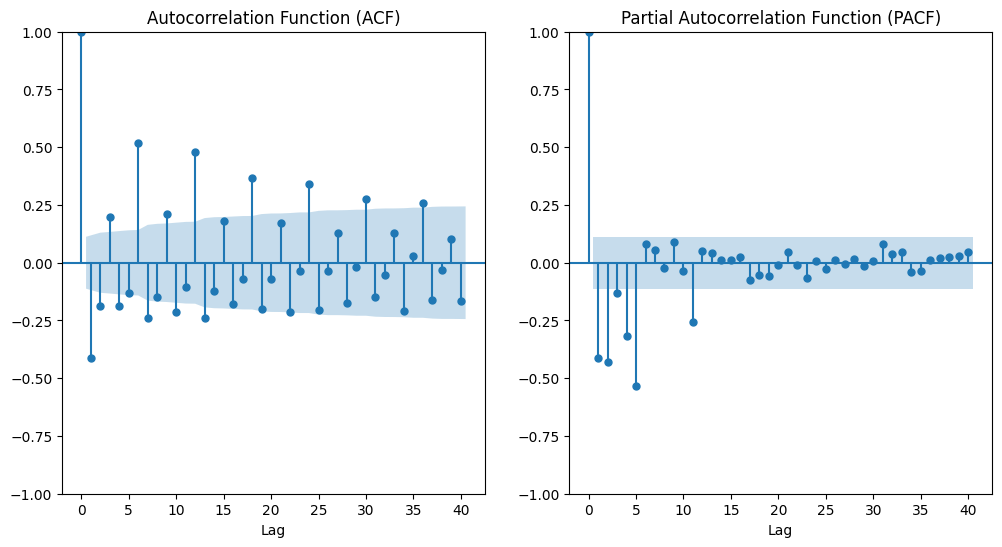

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(daily_sales['TotalSales_Diff'].dropna(), lags=40, ax=plt.gca())
plt.xlabel("Lag")
plt.title("Autocorrelation Function (ACF)")

# PACF plot
plt.subplot(122)
plot_pacf(daily_sales['TotalSales_Diff'].dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.xlabel("Lag") 
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

# Interpretation of ACF & PACF Plots

## 🔍 ACF (Left Plot) - Moving Average (MA) Component
- ACF shows significant positive spikes at multiple lags, slowly decreasing.  
- This suggests that the time series has a moving average (MA) component.  
- The slow decline indicates possible seasonality or a long-memory process.  

## 🔍 PACF (Right Plot) - Autoregressive (AR) Component
- The PACF plot shows a sharp cut-off after lag 2 or 3.  
- This suggests that the time series has an autoregressive (AR) component of order **p = 2 or 3**.  
- The drop beyond lag 3 suggests that higher-order lags do not contribute much.  

## 📌 Suggested ARIMA Model Parameters
- **p (AR order) =** 2 or 3 (based on PACF cutoff)  
- **d (Differencing) =** 1 (since first-order differencing made it stationary)  
- **q (MA order) =** 3 or 4 (based on ACF pattern)

## 5 Time Series Decomposition (Trend, Seasonality, Residuals)

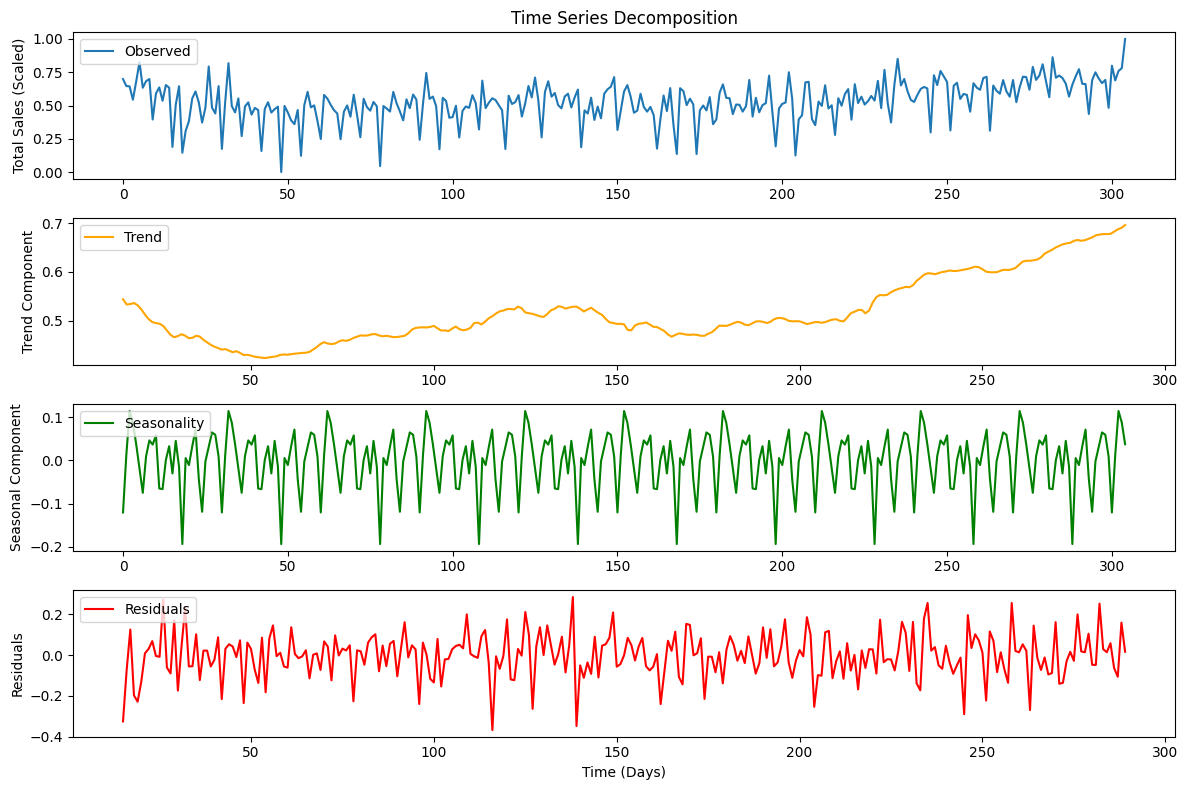

In [46]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(daily_sales["TotalSales_Scaled"], model='additive', period=30)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.ylabel("Total Sales (Scaled)")
plt.title("Time Series Decomposition")
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.ylabel("Trend Component")
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.ylabel("Seasonal Component")
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.ylabel("Residuals")
plt.xlabel("Time (Days)")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Time Series Decomposition Analysis

## 📊 Observed Series
- Shows fluctuations in sales, indicating some variations in trend and seasonality.  

## 📈 Trend Component
- Displays a downward trend initially, followed by an upward trend after around day 150.  
- Suggests a long-term pattern in the data.  

## 🔄 Seasonality Component
- Shows periodic fluctuations, confirming seasonal effects.  
- Example: Higher sales on specific intervals.  

## 🔍 Residuals
- Appear random with no strong pattern.  
- Suggests that the model has effectively captured trend and seasonality.

## 6 ARIMA Model Selection & Training

## 6.2 Grid Search for Best (p, d, q)

In [47]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define the p, d, q ranges
p = range(0, 5)  # Test values for AR terms
d = range(0, 2)  # Differencing order
q = range(0, 5)  # Test values for MA terms

# Generate all combinations of (p, d, q)
pdq_combinations = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
best_model = None

print("🔎 Performing Grid Search for ARIMA parameters...")

# Grid search
for pdq in pdq_combinations:
    try:
        model = ARIMA(daily_sales["TotalSales_Scaled"], order=pdq)  # Updated variable
        model_fit = model.fit()
        
        aic = model_fit.aic
        print(f"ARIMA{pdq} - AIC: {aic}")
        
        if aic < best_aic:
            best_aic = aic
            best_pdq = pdq
            best_model = model_fit
            
    except Exception as e:
        print(f"ARIMA{pdq} failed. Error: {e}")

print("\n✅ Best ARIMA Model:")
print(f"Order: {best_pdq}")
print(f"AIC: {best_aic}")

🔎 Performing Grid Search for ARIMA parameters...
ARIMA(0, 0, 0) - AIC: -286.77605350781977
ARIMA(0, 0, 1) - AIC: -303.7012519787784
ARIMA(0, 0, 2) - AIC: -301.7088083758871
ARIMA(0, 0, 3) - AIC: -309.1802791740354
ARIMA(0, 0, 4) - AIC: -311.438856246313
ARIMA(0, 1, 0) - AIC: -170.5362680324235
ARIMA(0, 1, 1) - AIC: -349.3535806015856


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2) - AIC: -347.3611640628028
ARIMA(0, 1, 3) - AIC: -358.9946152122981
ARIMA(0, 1, 4) - AIC: -357.03199269849523
ARIMA(1, 0, 0) - AIC: -304.9791308474639
ARIMA(1, 0, 1) - AIC: -348.33751058114876
ARIMA(1, 0, 2) - AIC: -346.34335793806724
ARIMA(1, 0, 3) - AIC: -358.43156132957733


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4) - AIC: -356.56791100046036
ARIMA(1, 1, 0) - AIC: -224.9779318959179
ARIMA(1, 1, 1) - AIC: -347.3582817909496
ARIMA(1, 1, 2) - AIC: -348.57426785209975
ARIMA(1, 1, 3) - AIC: -357.0309854228549


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4) - AIC: -363.1806396814343
ARIMA(2, 0, 0) - AIC: -304.1875714999094
ARIMA(2, 0, 1) - AIC: -346.34112264214264


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) - AIC: -345.3224424909634
ARIMA(2, 0, 3) - AIC: -356.566296351666


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4) - AIC: -361.67608600212697
ARIMA(2, 1, 0) - AIC: -285.3191711643031
ARIMA(2, 1, 1) - AIC: -355.40838031719085
ARIMA(2, 1, 2) - AIC: -354.67747064355603
ARIMA(2, 1, 3) - AIC: -391.0208346693146
ARIMA(2, 1, 4) - AIC: -396.79438003157475
ARIMA(3, 0, 0) - AIC: -320.8265472319159
ARIMA(3, 0, 1) - AIC: -354.5036958854166


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) - AIC: -343.4069191778833


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) - AIC: -388.05119947442046


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 4) - AIC: -393.348484946392
ARIMA(3, 1, 0) - AIC: -289.13939473138123
ARIMA(3, 1, 1) - AIC: -353.4251032052451
ARIMA(3, 1, 2) - AIC: -352.6854377432047
ARIMA(3, 1, 3) - AIC: -395.4692204191


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4) - AIC: -387.09001507096497
ARIMA(4, 0, 0) - AIC: -318.8711440027147
ARIMA(4, 0, 1) - AIC: -316.8867187709451


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 2) - AIC: -354.3293596548433


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 3) - AIC: -392.6081280659246


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 4) - AIC: -386.06777585552743
ARIMA(4, 1, 0) - AIC: -320.2897164196691
ARIMA(4, 1, 1) - AIC: -376.21742680771695
ARIMA(4, 1, 2) - AIC: -398.7549215548074


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 3) - AIC: -401.16463682169206
ARIMA(4, 1, 4) - AIC: -413.3629272586476

✅ Best ARIMA Model:
Order: (4, 1, 4)
AIC: -413.3629272586476


p = 4 → The model includes four autoregressive (AR) terms, meaning past values up to 4 lags are considered.

d = 1 → The data was differenced once to make it stationary.

q = 4 → The model includes four moving average (MA) terms, meaning past forecast errors up to 4 lags are considered.

## 7 Forecasting & Evaluation

### 7.1 Split Data into Train & Test

In [48]:
train_size = int(0.8 * len(daily_sales))
train, test = daily_sales[:train_size], daily_sales[train_size:]

print(f"Train data: {train.shape}, Test data: {test.shape}")

Train data: (244, 5), Test data: (61, 5)


### 7.2 Fit ARIMA Model & Forecast


📜 ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:      TotalSales_Scaled   No. Observations:                  244
Model:                 ARIMA(4, 1, 4)   Log Likelihood                 167.572
Date:                Thu, 27 Mar 2025   AIC                           -317.143
Time:                        11:55:13   BIC                           -285.705
Sample:                             0   HQIC                          -304.480
                                - 244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1943      0.134     -1.447      0.148      -0.457       0.069
ar.L2         -0.7950      0.114     -6.976      0.000      -1.018      -0.572
ar.L3          0.1107      0

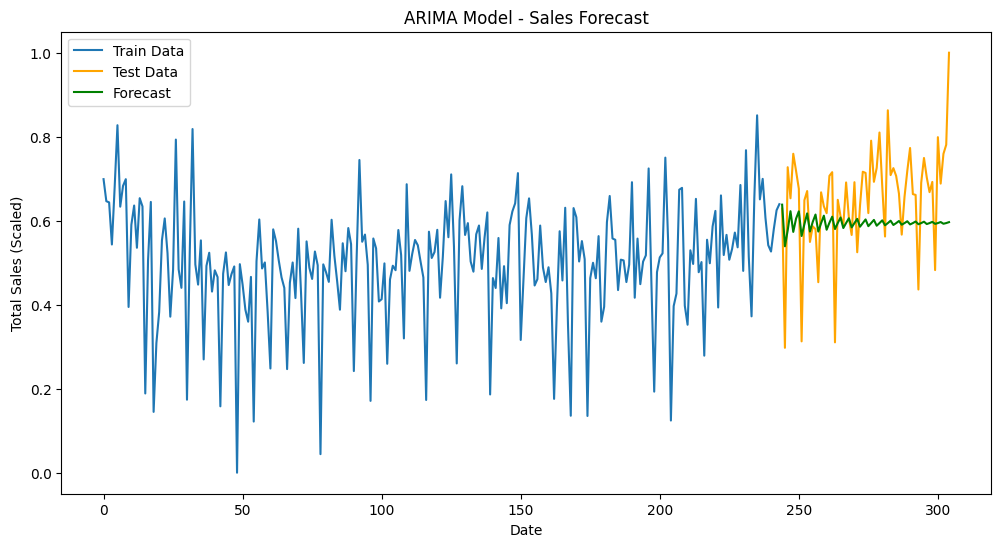

In [49]:
model = ARIMA(train["TotalSales_Scaled"], order=best_pdq)  # Updated variable
arima_model = model.fit()

print("\n📜 ARIMA Model Summary:")
print(arima_model.summary())

# Forecast
forecast = arima_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train["TotalSales_Scaled"], label='Train Data')
plt.plot(test.index, test["TotalSales_Scaled"], label='Test Data', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('ARIMA Model - Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales (Scaled)')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test["TotalSales_Scaled"], forecast)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.017233715342095637


### Lower MSE is better → Since MSE represents the average squared error between actual and predicted values, a lower value means the model is making more accurate predictions.

# 📈 Forecasting Plot Analysis

## 🔵 Training Data (Blue)
- Shows fluctuations in scaled total sales.  

## 🟠 Test Data (Orange)
- The actual future values continue to be volatile.  

## 🟢 Forecast (Green)
- The ARIMA model produces a relatively smooth forecast compared to actual test data.  
- The forecast seems to **underestimate variance** and fails to capture spikes and drops.  
- This suggests the model may not be capturing **seasonality or sudden changes** well.  

## 🔑 Key Inferences
### ✅ Decent Model Fit
- The selected **ARIMA(4,1,4)** model explains the trend but **fails to capture volatility**.  

### ⚠️ Residual Issues
- The **residuals are not normally distributed**, indicating potential model improvement is needed.  

### 📉 Underfitting Variance
- The forecast is **too stable** compared to test data, meaning:
  - It might **not be capturing seasonality** well.  
  - Alternative models like **SARIMA** (for seasonality) or **LSTMs/XGBoost** could be considered.  

## 🚀 Possible Next Steps
- ✅ **Check seasonality components** (use `seasonal_decompose`).  
- ✅ **Try SARIMA** to include seasonal effects.  
- ✅ **Compare MSE/RMSE** with a naive model (persistence model).  
- ✅ **Try hybrid models** (ARIMA + XGBoost or LSTMs).

-------------------------
# Use Prophet forecasting

## 2. Prepare the Dataset for Prophet

In [51]:
# Select relevant columns and rename for Prophet
df_prophet = daily_sales[['Date', 'TotalSales_Scaled']].copy()
df_prophet.rename(columns={'Date': 'ds', 'TotalSales_Scaled': 'y'}, inplace=True)

# Convert Date column to datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

df_prophet.head()

,ds,y
0,2010-12-01,0.698985
1,2010-12-02,0.646493
2,2010-12-03,0.643647
3,2010-12-05,0.543415
4,2010-12-06,0.680368


## 3 Handle Missing Values

In [52]:
# Ensure daily frequency and fill missing dates with 0
df_prophet = df_prophet.set_index('ds').asfreq('D', fill_value=0).reset_index()

# Replace zeros with mean value (excluding zeros)
mean_value = df_prophet['y'][df_prophet['y'] > 0].mean()
df_prophet['y'] = df_prophet['y'].replace(0, mean_value)

# Check for missing values
df_prophet.isnull().sum()

ds    0
y     0
dtype: int64

## 4 .Split Data into Training & Testing Sets

In [53]:
# Split 80% train, 20% test
train_size = int(0.8 * len(df_prophet))
train = df_prophet[:train_size]
test = df_prophet[train_size:]

print(f"Train size: {train.shape}, Test size: {test.shape}")

Train size: (299, 2), Test size: (75, 2)


## 5 Initialize & Train Prophet Model

In [54]:
from prophet import Prophet
# Initialize Prophet model
model = Prophet()
model.add_country_holidays(country_name='UK')  # Adding UK holidays for better accuracy

model.fit(train)

11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing


## 6 Forecast Future Values

In [55]:
# Generate future dates equal to the test set length
future = model.make_future_dataframe(periods=len(test))

# Get forecasted values
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
369,2011-12-05,0.574656,0.448787,0.696773
370,2011-12-06,0.624836,0.509656,0.747789
371,2011-12-07,0.560491,0.440797,0.679393
372,2011-12-08,0.615476,0.491050,0.728275
373,2011-12-09,0.561620,0.440723,0.679958


## 7 Plot the Prophet Forecast

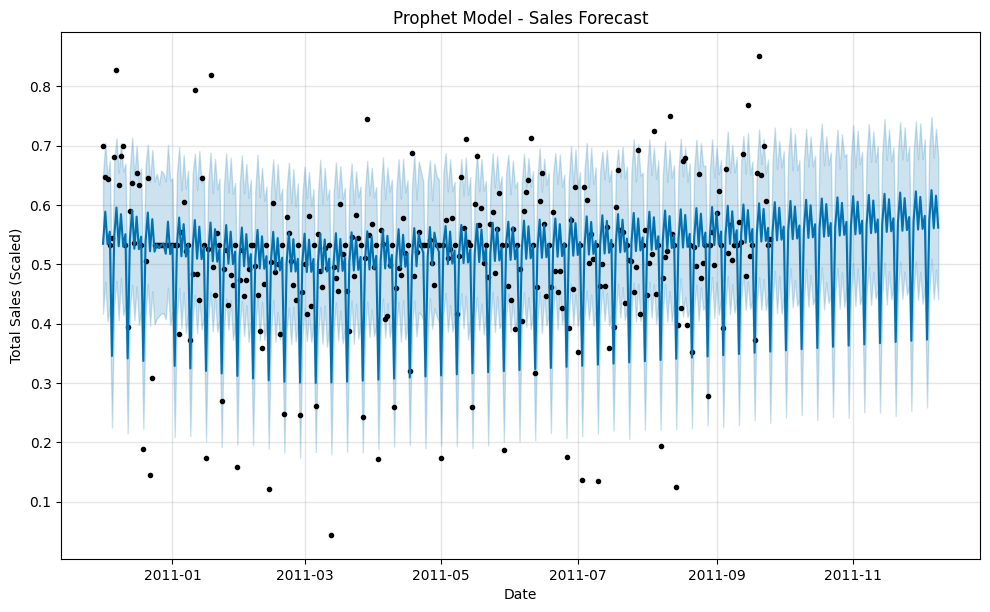

In [56]:
fig = model.plot(forecast)
plt.title("Prophet Model - Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Total Sales (Scaled)")
plt.show()

# Seasonality Patterns

- The model has captured **strong daily/weekly seasonality** (sharp fluctuations).  
- Sales appear to repeat a **cyclic pattern**, indicating periodic demand variations.  

## Uncertainty Bounds (Light Blue Shading)
- The lighter blue shaded region represents the **uncertainty interval**.  
- The **wider** the interval, the **higher the uncertainty** in predictions.  
- The interval remains **relatively stable**, indicating the model's confidence.  

## Trend Analysis
- A **slightly decreasing trend** is observed initially, followed by **stabilization**.  
- The model does not capture any **strong upward/downward trend**, implying **no major growth or decline** over time.  

## Outliers (Black Dots)
- Several **black dots** lie **outside the uncertainty bounds**.  
- This suggests **unusual sales spikes or drops**, possibly due to:
  - Special promotions  
  - Holidays  
  - External factors

## 8 Evaluate Model Performance (RMSE)

In [57]:
# Extract relevant forecasted and actual values
forecasted_values = forecast[['ds', 'yhat']].tail(len(test))
actual_values = test[['ds', 'y']]

# Merge actual and predicted values
comparison_df = pd.merge(forecasted_values, actual_values, on='ds', how='left')
comparison_df['error'] = comparison_df['y'] - comparison_df['yhat']

# Compute RMSE
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))
print(f'RMSE: {rmse}')

RMSE: 0.13026221081744369


# Error Magnitude

- **RMSE = 0.1302** (scaled revenue)  
- This means the model’s predictions **deviate from actual values by approximately 13% on average**.  
- Since the revenue is **scaled (likely between 0 and 1)**:
  - An error of **0.13 is moderate**—not too high but not extremely low either.

## 9 Visualize Actual vs. Predicted Values (Plotly)

In [58]:
import plotly.graph_objs as go

trace1 = go.Scatter(x=comparison_df['ds'], y=comparison_df['y'], mode='lines', name='Actual')
trace2 = go.Scatter(x=comparison_df['ds'], y=comparison_df['yhat'], mode='lines', name='Predicted')

layout = go.Layout(title="Actual vs Predicted Sales", xaxis={'title': 'Date'}, yaxis={'title': 'Total Sales (Scaled)'})
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Prediction Underestimation

- The **blue line (Actual Sales)** fluctuates significantly, while the **red line (Predicted Sales)** is smoother and stays lower.  
- This suggests that **Prophet is underestimating peak sales** and failing to capture large spikes.  

# Good Fit for General Trend

- The predicted line follows the **general trend** of actual sales.  
- This means Prophet understands **seasonality and trend components**, but struggles with **volatility**.  

# Missed Variability

- The actual values have **sharp peaks and dips**, while the model smooths out variations.  
- This indicates that the model is **not capturing sudden demand surges or drastic drops accurately**.  
---------------------

# K-Means clustering

 used to segment customers based on their purchasing behavior. This helps in: <br>
✅ Identifying high-value customers (who spend the most).<br>
✅ Finding frequent buyers (who make repeat purchases).<br>
✅ Optimizing marketing strategies (target different customer groups effectively). <br>

In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## 1 Load Dataset

In [60]:
sales_data = pd.read_csv('/kaggle/working/cleaned_data.csv', encoding='iso-8859-1', low_memory=False)

sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])

In [61]:
sales_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,2010-12-01


## 2 Aggregate Data by Customer

In [62]:
customer_sales = sales_data.groupby('CustomerID').agg({
    'TotalSales': 'sum',                 # Total revenue per customer
    'InvoiceNo': 'count',             # Purchase frequency
    'Quantity': 'sum'                 # Total items bought
}).rename(columns={'InvoiceNo': 'Frequency', 'Quantity': 'TotalQuantity'})

# Reset index
customer_sales = customer_sales.reset_index()

## 3 Scale the Data

In [63]:
# Scale the data before clustering
scaler = StandardScaler()
scaled_sales_data = scaler.fit_transform(customer_sales[['TotalSales', 'Frequency', 'TotalQuantity']])

## 4 Determine Optimal Clusters (Elbow Method)

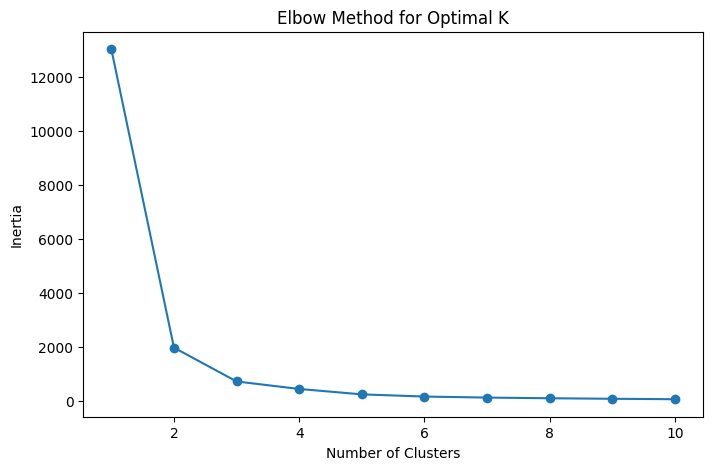

In [64]:
# Find the optimal number of clusters using inertia
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_sales_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

## 5 Perform Clustering with Optimal K

In [65]:
# Set optimal number of clusters (choosen based on the elbow plot)
optimal_k = 3

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_sales['Cluster'] = kmeans.fit_predict(scaled_sales_data)

## 6 Evaluate Clustering with Silhouette Score

In [66]:
sil_score = silhouette_score(scaled_sales_data, customer_sales['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.9776847939880878


## 7 Visualize Customer Clusters

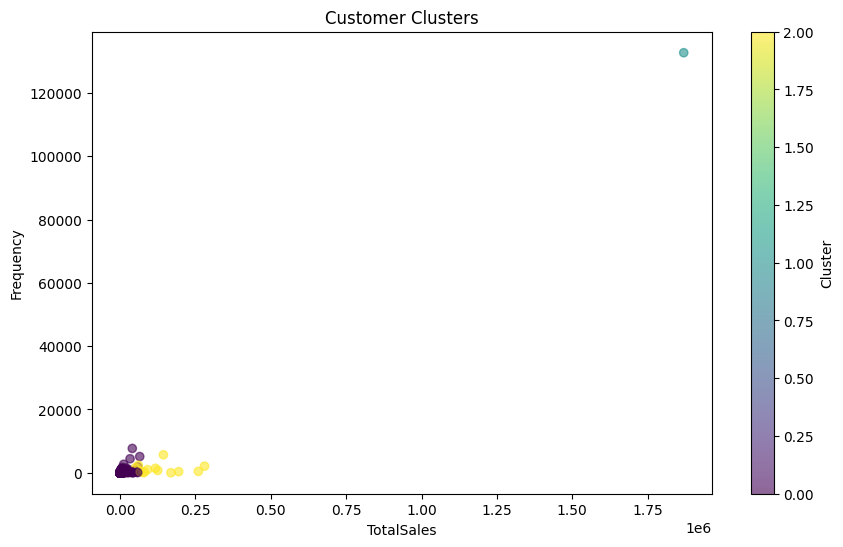

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(customer_sales['TotalSales'], customer_sales['Frequency'], 
            c=customer_sales['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Clusters')
plt.xlabel('TotalSales')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()

# Business Implications  

## ✔ Target High-Value Customers (Top Right Point)  
- Offer **VIP rewards, personalized discounts, or exclusive deals** to retain them.  

## ✔ Convert Low-Value Customers (Dense Bottom-Left Cluster)  
- These are **one-time or infrequent buyers**.  
- Use **email campaigns, promotions, or loyalty programs** to encourage repeat purchases.  

## ✔ Marketing & Sales Strategies  
- Design **different strategies for each cluster** rather than treating all customers the same.